# Elastic field around a penny-shaped (radial) crack under uniform tension

3D axi-symmetric Elastic problem 

Displacements and stresses around a flat penny-shaped crack  $ r \in [0,a], \theta \in [0,2\pi] $ under pure tensile loading $\sigma$.

We test the computation of the displacement and stress at observation points by setting the solution of the collocation BEM to the analytical solution on the BE mesh.


The crack displacement discontinuity is given  for $ r \in [0,a], \theta \in [0,2\pi]  $ as:

$\Delta u_z (r,\theta,z=0)= u_z (r,\theta,z=0^+)-u_z(r,\theta,z=0^-)=  \frac{8 \sigma}{ \pi E^\prime} \sqrt{a^2-r^2} =\frac{4 (1-\nu) \sigma}{\pi G} \sqrt{a^2-r^2}  $ 

$\Delta u_r (r,\theta,z=0)= \Delta u_\theta (r,\theta,z=0)= 0 $ 

where $E^\prime = E / (1-\nu^2) $ is the plane strain Young's modulus, $G = E/ (2(1+\nu)) $ the shear modulus, $E$ the Young's modulus and $\nu$ the Poisson's ratio.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
home = os.environ["HOME"]
print('getcwd:      ', os.getcwd())

# %% importing BigWham 

sys.path.append("/Users/bricelecampion/ClionProjects/BigWham_dev/build/interfaces/python")
from hmatrix import Hmatrix

from py_bigwham import Mesh

# load the analytical solution 
sys.path.append(os.path.join(os.getcwd(), '../../'))

from solutions.penny_shaped_crack_uniform import displacement_tensile_penny_shaped,stresses_tensile_penny_shaped

getcwd:       /Users/bricelecampion/ClionProjects/BigWham-Tutorials/examples/3d


In [2]:
#Elastic properties
G=1.
nu=0.15

rr =np.linspace(0.00001,10.,1000)

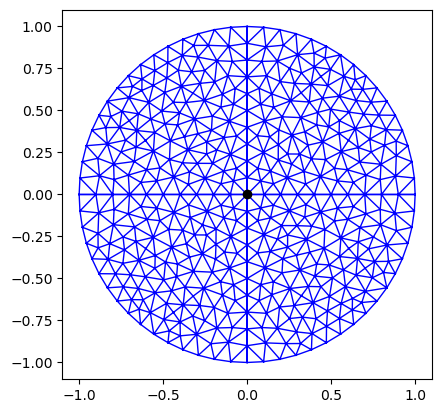

In [3]:
#%% mesh a circle with gmsh with a refinement in the center.
import pygmsh

center_res = 0.1
out_res = 0.1
Lx_ext = 1.

#   HERE 'wrong' ORIENTATION -> left hand rule .... 
with pygmsh.geo.Geometry() as geom:
    center_point = geom.add_point([0, 0,0], center_res)
    top_point = geom.add_point([0, Lx_ext,0], out_res )
    right_point = geom.add_point([Lx_ext, 0,0], out_res )
    bottom_point = geom.add_point([0.,-Lx_ext,0.],out_res)
    left_point =  geom.add_point([-Lx_ext,0.,0.],out_res)

    l1 = geom.add_line(center_point, top_point)
    arc1 = geom.add_circle_arc(top_point, center_point, right_point)
    l2 = geom.add_line(right_point, center_point)
    loop1 = geom.add_curve_loop([l1,arc1,l2])
    
    l3 = geom.add_line(center_point,right_point)
    arc2 = geom.add_circle_arc(right_point, center_point,bottom_point)
    l4 = geom.add_line(bottom_point,center_point)
    loop2 = geom.add_curve_loop([l3,arc2,l4])
    
    l5 = geom.add_line(center_point,bottom_point)
    arc3 = geom.add_circle_arc(bottom_point,center_point,left_point) 
    l6 = geom.add_line(left_point,center_point)   
    loop3 = geom.add_curve_loop([l5,arc3,l6])
    
    l7=geom.add_line(center_point,left_point)
    arc4 = geom.add_circle_arc(left_point,center_point,top_point)
    l8 = geom.add_line(top_point,center_point)
    loop4 = geom.add_curve_loop([l7,arc4,l8])
    
    geom.add_plane_surface(loop1)
    geom.add_plane_surface(loop2)
    geom.add_plane_surface(loop3)
    geom.add_plane_surface(loop4)
    
    geom.synchronize()
    g_mesh = geom.generate_mesh(order=1,algorithm=2)
    

g_mesh.points.shape[1]
coor=g_mesh.points
conn=g_mesh.cells_dict['triangle']
swap_c = conn.copy()
swap_c[:,0]=conn[:,2]
swap_c[:,2]=conn[:,0]
conn=swap_c

## plotting the unstructured mesh
import matplotlib
triang=matplotlib.tri.Triangulation(coor[:,0], coor[:,1], triangles=conn, mask=None)
fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
ax1.triplot(triang, 'b-', lw=1)
ax1.plot(0.,0.,'ko')
plt.show()


In [4]:
kernel = "3DT0"
elas_prop = np.array([2*G*(1+nu), nu])
eta=3.0
max_leaf_size = 64
eps_aca = 1.0e-3
h = Hmatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)
# checking that the mesh is properly ordered.... 
mm=Mesh(coor.flatten(),conn.flatten(),kernel)
all_norms =np.zeros((mm.num_elements(),3))
for e in range(mm.num_elements()):
    all_norms[e]=mm.get_element_normal(e)
np.mean(all_norms[:,2]) 


 Now setting things for kernel ... 3DT0 with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  0.000414
 binary cluster tree depth =5
 Number of blocks =220
 Number of full blocks =120
 Number of low rank blocks =100
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 120 
Loop on low rank blocks construction
N low rank blocks 100
dof_dimension: 3
Creation of hmat done in 0.707402
Compression ratio - 0.57161
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 0.57161, eps_aca = 0.001, eta = 3
Hierarchical matrix  construction time = :  0.707433
--------------------


1.0

In [5]:
# collocation points - to compute analytical solutionm for width and then estimate stress & displacement at observations points
colpts=h.getCollocationPoints()
r_col = np.sqrt(colpts[:,0]**2+colpts[::,1]**2)
# Crack opening displacement discontinuity from analytical solution 
a=1
w = (4*(1-nu)/(G*np.pi))*np.sqrt(a**2-r_col**2)   
#  all DDs....
d = np.transpose([w*0.,w*0.,w])

# observation points
r_obs = rr
z_obs=0.6

obs_pts = np.transpose([r_obs , 0.*r_obs, r_obs*0.+z_obs])

sxx,syy,szz,sxy,sxz,syz  =stresses_tensile_penny_shaped(r_obs,r_obs*0,z_obs,a=1,sig=1,nu=nu,G=G)


# computation of stress observations from bigwham
import time
zt = time.process_time()
stress=h.compute_stresses(obs_pts,-d)   # minus sign due to convention of positive dd in overlap in the inner of Bigwham....
zt = time.process_time()
elapsed = (time.process_time() - zt) 
print("number of active threads for Bigwham", h.get_omp_threads())
print("elapsed time", elapsed)

DispatchError: Function <code object get_omp_threads at 0x7f88f08aec30, file "/Users/bricelecampion/ClionProjects/BigWham_dev/cmake-build-release/interfaces/python/hmatrix.py", line 129>

0.004659184791828445

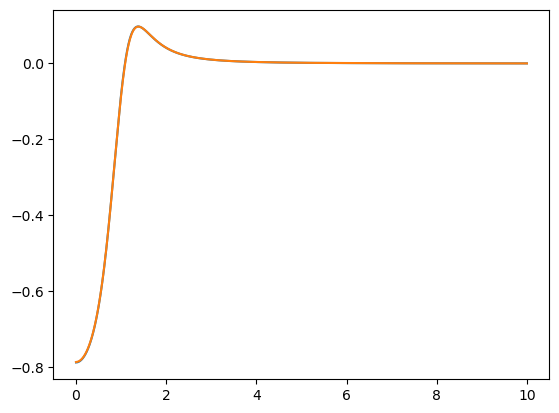

In [ ]:
import matplotlib.pyplot as plt

# evolution of szz along x at z=z_offset
plt.plot(r_obs,szz)
plt.plot(r_obs,stress[:,2])
np.median(np.abs((szz-stress[:,2])/szz))

0.004535003854244794

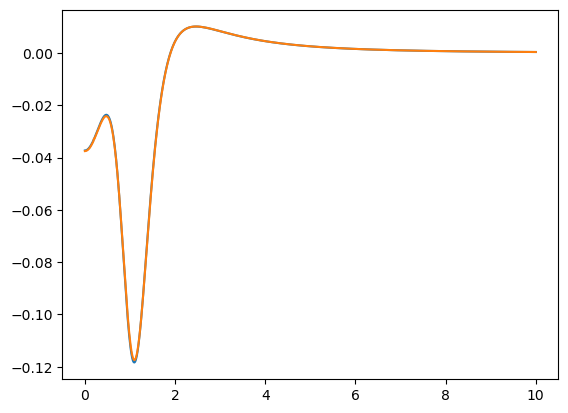

In [6]:
# evolution of srr=sxx along x at z=z_offset
plt.plot(r_obs,sxx)
plt.plot(r_obs,stress[:,0])
np.median(np.abs((sxx-stress[:,0])/sxx))

0.004404058070857304

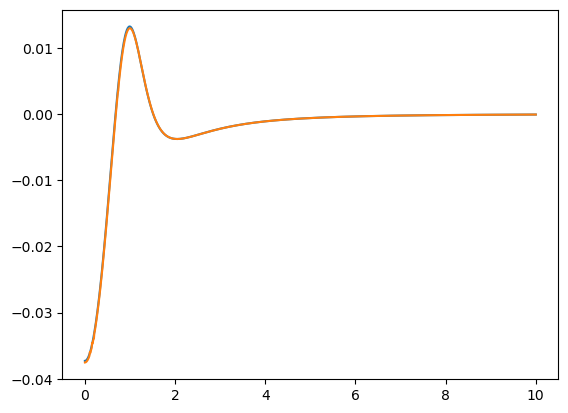

In [7]:
# evolution of stt=s22 along x at z=z_offset
plt.plot(r_obs,syy)         # hummmm 
plt.plot(r_obs,stress[:,1])   
np.median(np.abs((syy-stress[:,1])/syy))

0.004724628607072185

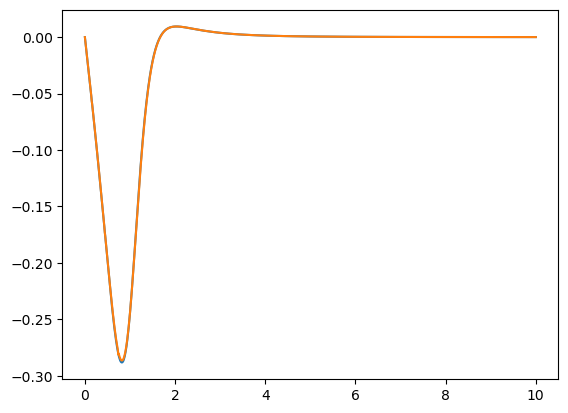

In [8]:
# evolution of srz=s13 along x at z=z_offset
plt.plot(r_obs,sxz)
plt.plot(r_obs,stress[:,4])
np.median(np.abs((sxz-stress[:,4])/sxz))

4.328871517832455e-09

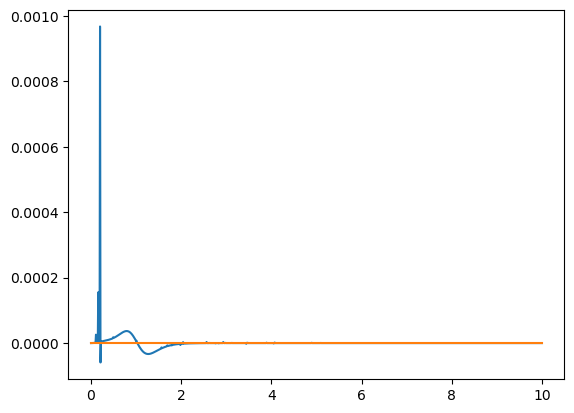

In [9]:
# evolution of srt=s12 along x at z=z_offset
plt.plot(r_obs,stress[:,3])
plt.plot(r_obs,sxy)
np.median(np.abs((sxy-stress[:,3])))

1.4039242432675745e-09

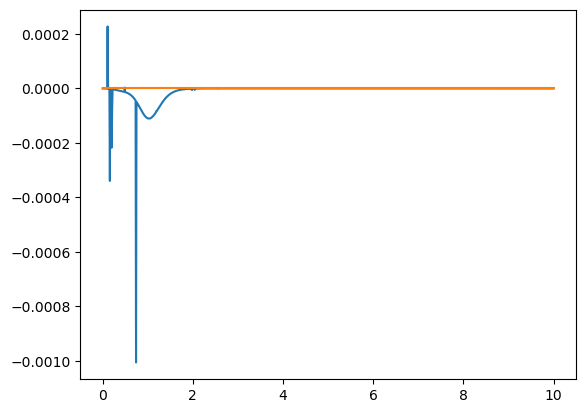

In [10]:
# evolution of stz=s23 along x at z=z_offset
plt.plot(r_obs,stress[:,5])
plt.plot(r_obs,syz)
np.median(np.abs((syz-stress[:,5])))

In [11]:
# displacements
u_x,u_y,u_z=displacement_tensile_penny_shaped(rr,0.*rr,z_obs,a=1,sig=1,nu=nu,G=G)

# via collocation bem
disp=h.compute_displacements(obs_pts,-d)   # minus sign due to convention of positive dd in overlap in the inner of Bigwham....


0.004487682760344421

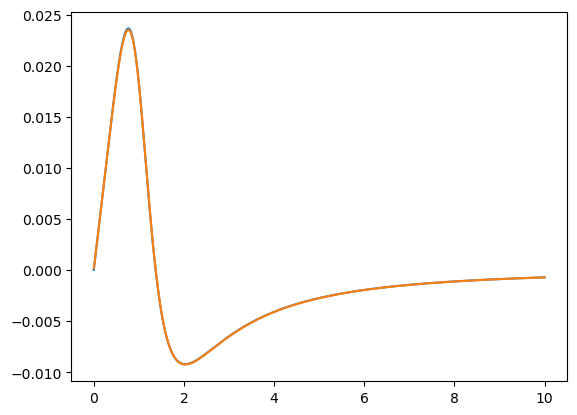

In [12]:
plt.plot(r_obs,u_x)
plt.plot(r_obs,disp[:,0])
np.median(np.abs((u_x-disp[:,0])/u_x))

0.004678808041959345

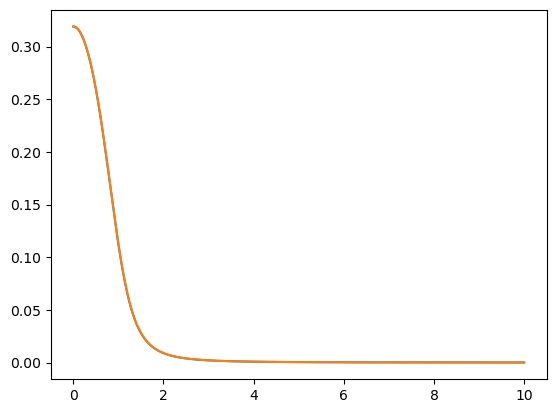

In [13]:
plt.plot(r_obs,u_z)
plt.plot(r_obs,disp[:,2])
np.median(np.abs((u_z-disp[:,2])/u_z))

In [14]:
# displacements along another line 
obs_pts_2 =  np.transpose([1.*r_obs+1.3 , 0.*r_obs+0.02,0.1+ 0*r_obs])
u_x,u_y,u_z=displacement_tensile_penny_shaped(obs_pts_2[:,0],obs_pts_2[:,1],obs_pts_2[:,2],a=1,sig=1,nu=nu,G=G)

# via collocation bem
disp=h.compute_displacements(obs_pts_2,-d)   # minus sign due to convention of positive dd in overlap in the inner of Bigwham....


0.004507080335471255

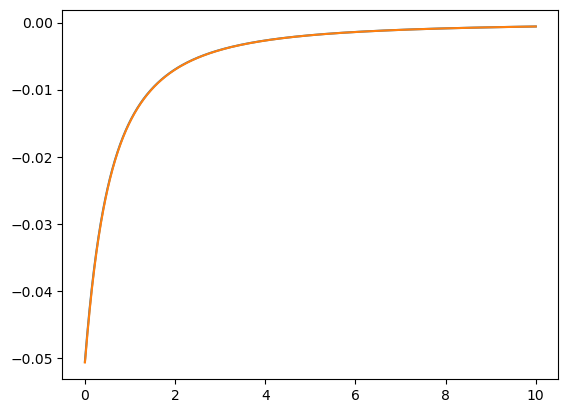

In [15]:
plt.plot(r_obs,u_x)
plt.plot(r_obs,disp[:,0])
np.median(np.abs((u_x-disp[:,0])/u_x))

0.004619624140866571

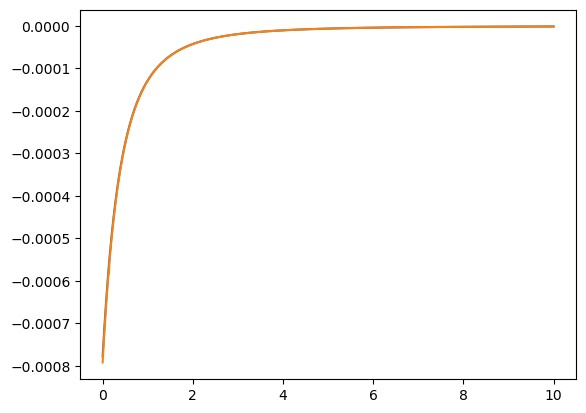

In [16]:
plt.plot(r_obs,u_y)
plt.plot(r_obs,disp[:,1])
np.median(np.abs((u_y-disp[:,1])/u_y))

0.0046374008954736725

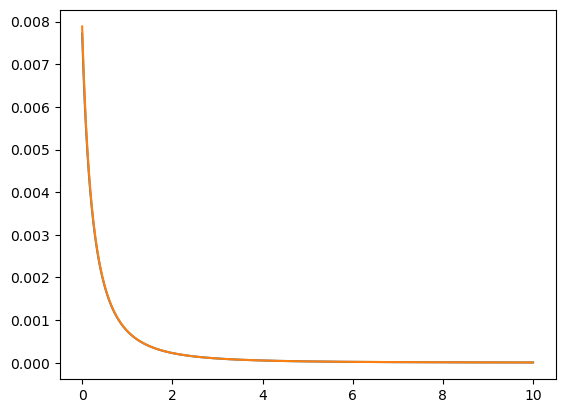

In [17]:
plt.plot(r_obs,u_z)
plt.plot(r_obs,disp[:,2])
np.median(np.abs((u_z-disp[:,2])/u_z))